
# **Modelos de clasificación**

### **Librerias:**

In [1]:
# Importing necessary libraries
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import time  # For tracking execution time

# Importing modules from scikit-learn for model building and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data and hyperparameter tuning
from sklearn.pipeline import Pipeline  # For creating machine learning pipelines
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.linear_model import Ridge, Lasso  # For regression models
from sklearn.ensemble import RandomForestRegressor  # For ensemble regression model

# Importing XGBoost library for regression
from xgboost import XGBRegressor  # For gradient boosting regression

# Importing metrics for model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error  # For evaluating regression models

In [2]:
df = pd.read_csv('..\df_final.csv')  # Load the dataset
print("Filas disponibles:", len(df))


Filas disponibles: 1535519


## **Balanceo de clases**

En *Machine Learning*, una clase se refiere a una de las categorías en las que se agrupan las observaciones dentro de un problema de clasificación. En un conjunto de datos etiquetado, cada instancia está asociada a una clase específica, permitiendo que un modelo aprenda a predecir la categoría correcta para nuevas observaciones.
Cuando el número de ejemplos en cada clase está desproporcionado, se habla de un **desbalance de clases**. Esto ocurre cuando una clase tiene significativamente más ejemplos que otra(s), afectando el desempeño del modelo de clasificación. En estas situaciones, el algoritmo tiende a favorecer la clase mayoritaria, lo que puede llevar a una alta precisión global, pero con un desempeño deficiente en la clase minoritaria.

Para mitigar este problema, se emplean técnicas de balanceo de clases, cuyo objetivo es modificar la distribución de los datos o ajustar la forma en que el modelo aprende. En este estudio, se implementarán tres enfoques principales:

* SMOTE (Synthetic Minority Over-sampling Technique): Es una técnica de sobremuestreo que genera nuevas instancias sintéticas de la clase minoritaria a partir de interpolaciones entre ejemplos existentes.
* ADASYN (Adaptive Synthetic Sampling): Similar a SMOTE, pero con la particularidad de generar más ejemplos en aquellas regiones donde la clase minoritaria es más dispersa, mejorando la representatividad del conjunto de datos.
* Ajuste de pesos con `class_weight='balanced`: Método que modifica la función de costo del modelo para penalizar más los errores en la clase minoritaria, sin necesidad de generar nuevos datos.


## **Contextualización**

Pasra la evaluación de los moodelos de clasificación, se eligió la variable `LOCALITY` como objetivo de los modelos de clasificación con el fin de explorar la posibilidad de identificar microclimas urbanos dentro de la ciudad de Barranquilla. Cada localidad representa una zona geográfica con características urbanas, ambientales y espaciales distintas (algunas más cercanas a cuerpos de agua, otras más densamente urbanizadas o con menor cobertura vegetal).

Al utilizar variables meteorológicas como temperatura, humedad, presión y viento como entradas del modelo, se busca evaluar si estas condiciones permiten distinguir de manera significativa entre las distintas zonas de la ciudad. Esta elección permite no solo explorar la variabilidad climática a escala intraurbana, sino también probar la capacidad de los modelos de ML para detectar patrones geográficos sutiles basados en datos atmosféricos.

### **Verificación de balance de clases**

LOCALITY
Sur          307104
Occidente    307104
Oriente      307104
Norte        307104
Centro       307103
Name: count, dtype: int64


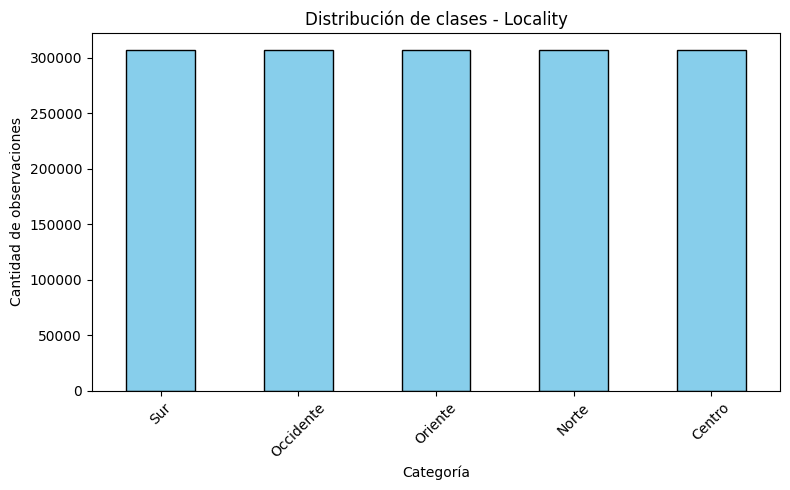

In [3]:
class_counts = df['LOCALITY'].value_counts()

# Mostrar el conteo
print(class_counts)

# Visualización del balance de clases
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribución de clases - Locality")
plt.xlabel("Categoría")
plt.ylabel("Cantidad de observaciones")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La distribución de las clases en la variable "localidad" es bastante equilibrada, ya que cada localidad (Sur, Oriente, Occidente, Norte y Centro) tiene un número similar de registros, con una pequeña diferencia en la localidad Centro. Dado que no se observa un desbalance significativo entre las clases, no es necesario aplicar técnicas de balanceo de clases, como SMOTE o ADASYN, para este conjunto de datos.

## **Modelos Benchmark**

Ya teniendo la certeza de que las clases seencuentran balanceada, se procede entonces a ejecutar los modelos de referencia para el modelo de clasificación, en este caso ejecutaremos K-Nearest Neighbors (KNN), Clasificación de Bayes, Regresión Logística (Regularización L1/L2 - Ridge, Lasso respectivamente), Decision Tree, Random Forest, XGBoost (Lime), y Máquinas de Soporte Vectorial (SVM). Para cada caso analizaremos...

## **Implementación de los modelos (sin optimización)**

### **KNN (K-Nearest Neighbors)**

In [4]:
# === Librerías necesarias ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [5]:
# === Codificar variable objetivo: LOCALITY ===
le = LabelEncoder()
df['LOCALITY_encoded'] = le.fit_transform(df['LOCALITY'])

# ===  Seleccionar variables de entrada (X) ===
features = ['T2M', 'RH2M', 'PRECTOTCORR', 'WS10M', 'WD10M',
            'PS', 'ALLSKY_SFC_UV_INDEX', 'ALLSKY_SFC_SW_DIFF',
            'T2MDEW', 'T2MWET', 'WS50M', 'SolarIndex']

X = df[features]
y = df['LOCALITY_encoded']

# === División train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === Escalar ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
accuracy_vals = []
best_acc = 0
best_k = 1

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    if acc > best_acc:
        best_acc = acc
        best_k = k

    accuracy_vals.append(acc)
    print(f"Accuracy para k={k}: {acc:.4f}")

print(f"\nMejor accuracy: {best_acc:.4f} con k={best_k}")

# Graficar resultados
pd.DataFrame(accuracy_vals).plot(figsize=(8,5), legend=False)
plt.title("Accuracy vs K")
plt.xlabel("Valor de k")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [44]:


# === Definir modelo KNN ===
knn = KNeighborsClassifier(n_neighbors=2)

# === Validación cruzada ===
cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Promedio de accuracy en CV:", cv_scores.mean())

# === Entrenamiento final y predicción (medimos tiempo) ===
start_time = time.time()

knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
y_proba = knn.predict_proba(X_test_scaled)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tiempo de cómputo (KNN sin optimización): {elapsed_time:.4f} segundos")


# === Reporte de clasificación ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Cross-validation scores: [0.22099519 0.2218139  0.22179995 0.22197309 0.22196379]
Promedio de accuracy en CV: 0.22170918574600978
Tiempo de cómputo (KNN sin optimización): 20.6739 segundos
=== Classification Report ===
              precision    recall  f1-score   support

      Centro       0.19      0.34      0.24     92131
       Norte       0.34      0.48      0.40     92131
   Occidente       0.16      0.16      0.16     92131
     Oriente       0.18      0.11      0.14     92132
         Sur       0.10      0.01      0.03     92131

    accuracy                           0.22    460656
   macro avg       0.19      0.22      0.19    460656
weighted avg       0.19      0.22      0.19    460656



El modelo KNN fue evaluado mediante validación cruzada con 5 particiones (5-fold cross-validation), arrojando valores de precisión (accuracy) bastante consistentes entre los diferentes pliegues: 0.2210, 0.2218, 0.2218, 0.2220 y 0.2220. Estas puntuaciones reflejan un rendimiento estable, aunque modesto, con un promedio general de accuracy de 0.2217, es decir, el modelo logró clasificar correctamente la localidad en aproximadamente el 22.1% de los casos. Este desempeño limitado puede atribuirse a la similitud entre condiciones meteorológicas de distintas zonas de la ciudad, lo que dificulta que el modelo identifique patrones claramente diferenciables.

El tiempo de cómputo total para entrenar el modelo y realizar las predicciones fue de 22.05 segundos, lo que servirá como referencia para evaluar la eficiencia de versiones optimizadas del modelo, como aquellas que utilicen estructuras de datos como KD-Tree o Ball-Tree.

En cuanto a las métricas por clase, el modelo mostró mayor capacidad de predicción para la localidad Norte, alcanzando una precisión de 0.34, un recall de 0.48 y un F1-score de 0.40. Esto indica que, cuando el modelo predice “Norte”, acierta el 34% de las veces, y que de todos los casos reales de esa localidad, logra identificar correctamente el 48%. Por el contrario, otras zonas como Sur y Oriente presentaron desempeños notablemente más bajos, con F1-scores de apenas 0.03 y 0.14, respectivamente, lo cual revela una alta tasa de errores al clasificar estas localidades.

El accuracy global del modelo fue del 22%, lo que confirma que la tarea de clasificación entre zonas geográficas basándose únicamente en variables meteorológicas representa un reto considerable. Además, los promedios macro y ponderado (weighted) para precisión, recall y F1-score se ubicaron en torno a 0.19–0.22, indicando que el bajo rendimiento es consistente a lo largo de todas las clases, sin que una en particular esté sesgando los resultados generales.

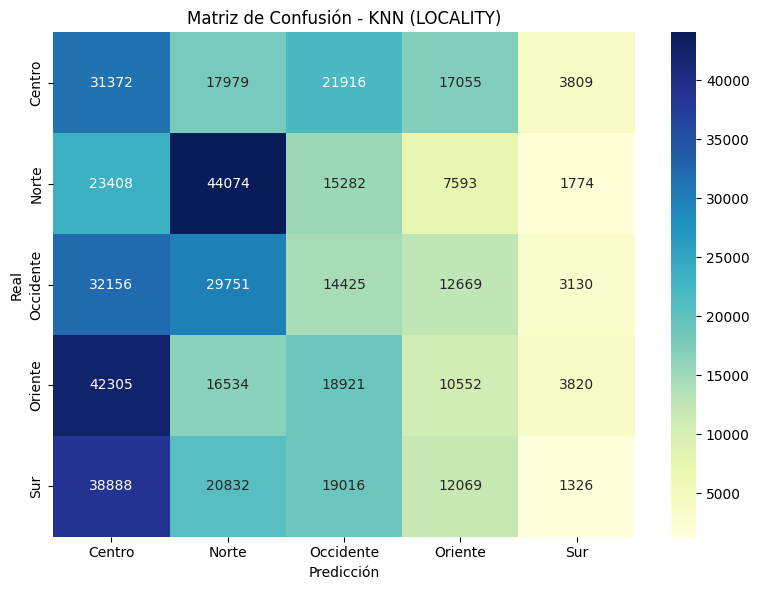

In [8]:
# === 11. Matriz de Confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='YlGnBu')
plt.title("Matriz de Confusión - KNN (LOCALITY)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


La matriz de confusión presentada resume el desempeño del modelo KNN al clasificar las cinco localidades de Barranquilla: Centro, Norte, Occidente, Oriente y Sur. En ella, las filas representan las localidades reales y las columnas las predicciones del modelo. Los valores diagonales (de arriba a la izquierda hacia abajo a la derecha) indican las predicciones correctas, mientras que los demás representan errores de clasificación.

A simple vista, se observa que el modelo tiene un mejor desempeño reconociendo correctamente las muestras de la localidad Norte, con 44.074 predicciones acertadas. Sin embargo, también se perciben altos niveles de confusión entre localidades vecinas o climáticamente similares. Por ejemplo, se evidencia lo siguiente:

* Muchas observaciones de Centro fueron clasificadas como Occidente (21.916) u Oriente (17.055).

* Un número considerable de observaciones reales de Oriente fueron clasificadas como Centro (42.305) o Occidente (18.921).

* Las predicciones correctas para Sur fueron apenas 1.326 (muy por debajo de sus errores hacia Centro, Norte u Occidente, con más de 38.000, 20.000 y 19.000 respectivamente).

Este patrón sugiere que el modelo sigue teniendo dificultades para distinguir claramente entre ciertas zonas de la ciudad, lo cual puede deberse a similitudes en sus variables meteorológicas o a la cercanía geográfica entre localidades que comparten microclimas.

En general, la matriz confirma lo que ya se había evidenciado en el classification report: el modelo tiende a confundirse con frecuencia, especialmente en zonas como Sur y Oriente, y acierta con mayor facilidad en localidades que presentan patrones climáticos más diferenciados (como Norte).

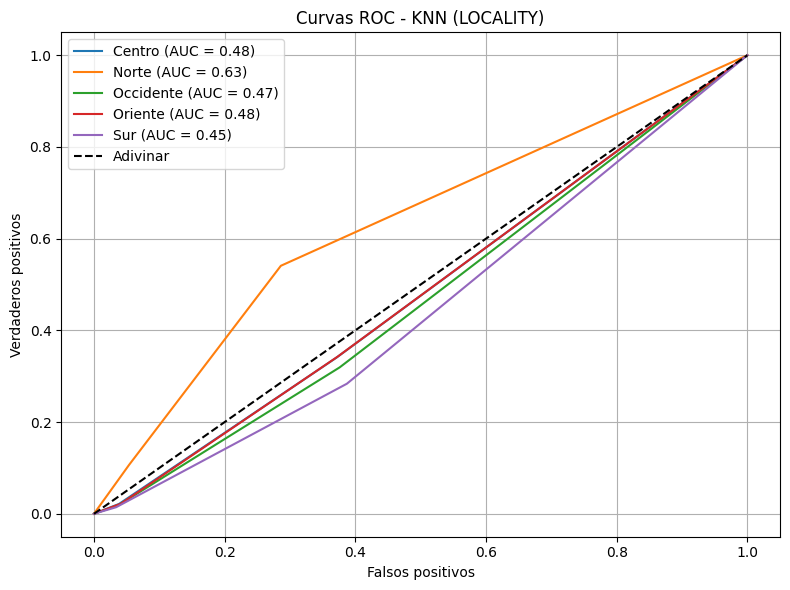

In [12]:

# === 12. Curvas ROC por clase + AUC por clase ===
plt.figure(figsize=(8, 6))
auc_scores = []

for i, class_label in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test == i, y_proba[:, i])
    auc = roc_auc_score(y_test == i, y_proba[:, i])
    auc_scores.append(auc)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.title("Curvas ROC - KNN (LOCALITY)")
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Las curvas ROC obtenidas evidencian una capacidad moderadamente limitada del modelo para distinguir entre las distintas localidades de Barranquilla, con excepción de la localidad Norte, que presenta un AUC de 0.63. Este valor sugiere un desempeño aceptable, aunque no óptimo, en la capacidad del modelo para identificar correctamente esta clase frente a las demás. Para el resto de las localidades, los valores de AUC se mantienen cercanos al umbral de referencia aleatoria (0.50), con Centro y Oriente en 0.48, Occidente en 0.47 y Sur en 0.45. Estos resultados confirman que, aunque el modelo muestra una ligera mejora general respecto a la ejecución anterior, sigue teniendo dificultades importantes para diferenciar entre la mayoría de las zonas geográficas. En conjunto, las curvas ROC refuerzan la conclusión de que el modelo logra cierto grado de discriminación para la localidad Norte, pero no presenta una capacidad robusta y generalizable para separar correctamente todas las clases. Esto limita su utilidad como clasificador efectivo en un contexto donde se requiere precisión en la identificación de microclimas urbanos.





In [14]:

# === 13. AUC promedio (macro) ===
auc_macro = np.mean(auc_scores)
print(f"AUC promedio (macro): {auc_macro:.4f}")

AUC promedio (macro): 0.5015


Además, el AUC (Area Under the Curve) promedio (macro) calculado para el modelo fue de 0.5015, lo que indica que, en promedio, la capacidad del modelo para distinguir correctamente entre una clase y el resto es apenas ligeramente superior al azar (que sería 0.50). 

### **Bayes**

In [45]:

from sklearn.naive_bayes import GaussianNB

# --- División y escalado ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 1. Entrenamiento y medición de tiempo ---
start_time = time.time()
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Tiempo de entrenamiento (Naive Bayes sin optimización): {training_time:.4f} segundos")

# --- 2. Predicción y métricas ---
y_pred = nb_model.predict(X_test)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Tiempo de entrenamiento (Naive Bayes sin optimización): 0.2146 segundos

Reporte de Clasificación:
              precision    recall  f1-score   support

      Centro       0.25      0.03      0.06     92131
       Norte       0.31      0.99      0.47     92131
   Occidente       0.19      0.02      0.03     92131
     Oriente       0.25      0.28      0.26     92132
         Sur       0.24      0.11      0.15     92131

    accuracy                           0.28    460656
   macro avg       0.25      0.28      0.19    460656
weighted avg       0.25      0.28      0.19    460656



El modelo de Clasificación Bayesiana fue entrenado utilizando el algoritmo GaussianNB, obteniendo un tiempo de entrenamiento extremadamente bajo de 0.2045 segundos, lo cual representa una ventaja considerable en términos de eficiencia computacional. Sin embargo, en cuanto a desempeño predictivo, el modelo alcanzó una precisión global (accuracy) de 28%, lo que significa que logró clasificar correctamente la localidad correspondiente en menos de un tercio de los casos. Esto sugiere que, aunque el modelo es rápido, su capacidad para diferenciar entre zonas geográficas a partir de condiciones meteorológicas aún es limitada.

El análisis por clase revela un patrón de desempeño muy desigual. La clase “Norte” sobresale con un recall de 0.99, lo que indica que el modelo identificó correctamente casi todos los casos reales de esa localidad. No obstante, este resultado también sugiere un sesgo fuerte hacia dicha clase, ya que las demás localidades presentan valores de recall significativamente más bajos: Centro (0.03), Occidente (0.02), Oriente (0.28) y Sur (0.11). En cuanto al F1-score, que equilibra precisión y recall, solo Norte alcanza un valor destacable de 0.47, mientras que las demás clases tienen puntuaciones muy bajas (de 0.03 a 0.26), reflejando una falta de equilibrio en la predicción.

El promedio macro de recall fue 0.28, ligeramente superior al de precisión (0.25) y F1-score (0.19). Debido al fuerte desequilibrio entre clases, se opta por utilizar recall macro promedio como métrica principal de validación, ya que permite evaluar qué tan bien se están reconociendo correctamente todas las clases sin verse influenciado por el tamaño de cada una

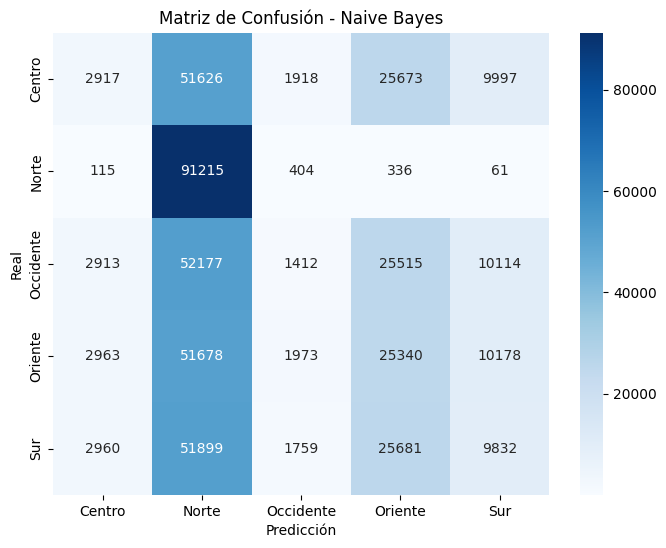

In [46]:
# --- 3. Matriz de confusión con nombres correctos ---
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Naive Bayes")
plt.show()


La matriz de confusión muestra que el modelo Naive Bayes tiene un fuerte sesgo hacia la clase “Norte”, ya que la mayoría de las predicciones, sin importar la clase real, terminan clasificadas como “Norte”. Por ejemplo, de los casos reales de “Occidente”, más de 52 mil fueron clasificados incorrectamente como “Norte”, y solo unos 2.900 fueron correctamente identificados. Esta tendencia se repite en todas las demás clases.

Aunque el modelo logra identificar con precisión casi todos los casos reales de “Norte” (lo que se ve en la celda [Norte, Norte] con más de 91 mil aciertos), su capacidad para diferenciar entre las otras localidades es muy baja, ya que la mayoría son absorbidas por esa clase dominante.

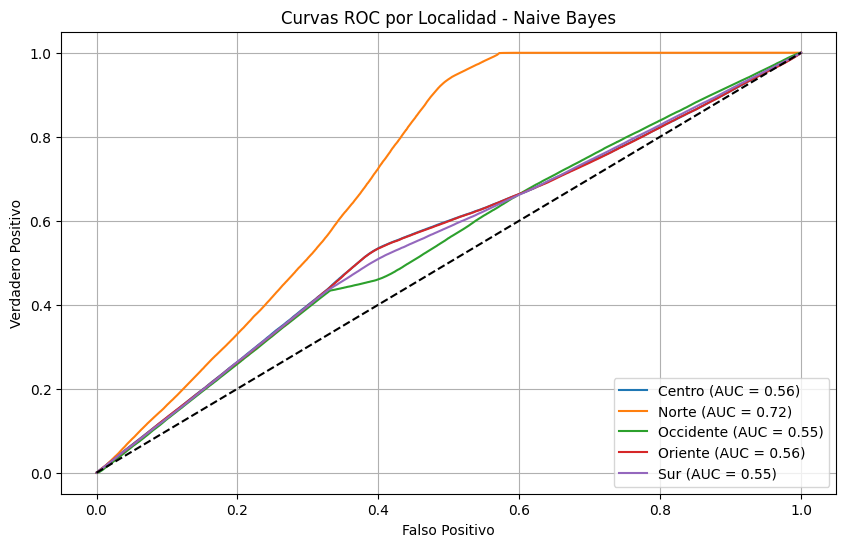

In [23]:
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc
)
# --- 4. ROC y AUC ---
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = nb_model.predict_proba(X_test)

# ROC por clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro y macro promedio
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Curvas ROC con nombres
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadero Positivo")
plt.title("Curvas ROC por Localidad - Naive Bayes")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- 5. Tabla resumen de métricas ---
metrics_df = pd.DataFrame({
    "Modelo": ["Clasificación Bayesiana"],
    "precision": [precision_score(y_test, y_pred, average="macro")],
    "recall": [recall_score(y_test, y_pred, average="macro")],
    "accuracy": [accuracy_score(y_test, y_pred)],
    "f1-score": [f1_score(y_test, y_pred, average="macro")],
    "AUC": [roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")]
})


Las curvas ROC por localidad confirman el comportamiento desigual del modelo Naive Bayes. La única clase con una curva claramente separada de la línea base (AUC > 0.7) es Norte, lo que indica que el modelo tiene una capacidad real de distinguir correctamente los casos de esa clase. Su AUC de 0.72 respalda lo observado en la matriz de confusión y el classification report, predice muy bien "Norte", pero "descuida" las demás.

Para las otras localidades, los valores de AUC se encuentran entre 0.55 y 0.56, muy cercanos al azar (0.5), lo cual refleja que el modelo no tiene una capacidad significativa de discriminar entre clases en esos casos. Esto refuerza la conclusión de que, aunque el modelo es rápido, no está captando patrones diferenciadores suficientes para predecir con fiabilidad la localidad en función de las variables meteorológicas disponibles.

In [47]:
print("\nTabla de métricas")
display(metrics_df)



Tabla de métricas


,Modelo,precision,recall,accuracy,f1-score,AUC
0,Clasificación Bayesiana,0.246438,0.283761,0.283761,0.192059,0.586175


La tabla de métricas del modelo Naive Bayes muestra un rendimiento modesto y consistente con el resto de las evaluaciones. El accuracy general fue de 0.2837, lo que significa que el modelo acierta la predicción de la localidad en aproximadamente un 28% de los casos. La precisión (0.246) y el **recall macro promedio** (0.283) son similares, lo que indica que el modelo no solo comete errores al clasificar, sino que también deja de identificar correctamente muchas muestras de clases diferentes a la dominante.

El F1-score promedio fue de apenas 0.192, reflejando la incapacidad del modelo para balancear precisión y sensibilidad en la mayoría de las clases. Por otro lado, el AUC macro promedio fue 0.586, apenas por encima del valor aleatorio (0.5), lo que sugiere que la capacidad del modelo para distinguir entre clases es limitada.

#### **Métrica seleccionada**
Para evaluar el desempeño del modelo Naive Bayes, se seleccionó el recall macro promedio como métrica principal de validación. Esta métrica calcula el recall de cada clase por separado y luego hace un promedio simple, sin ponderar por la cantidad de muestras en cada clase. Es decir, todas las clases tienen el mismo peso, lo que permite medir de forma justa qué tan bien el modelo logra identificar correctamente cada una, independientemente de su frecuencia.

Esta elección la consideramos adecuada en este caso porque el modelo mostró un comportamiento muy sesgado hacia la clase "Norte", mientras que el desempeño en las demás localidades fue considerablemente inferior. Usar métricas como accuracy o recall ponderado podría ocultar ese desequilibrio, ya que se verían influidas por la clase dominante. En cambio, el recall macro permite visibilizar este problema y refleja de forma más "honesta" la capacidad del modelo para distinguir entre todas las zonas geográficas involucradas en la clasificación.

### **Ridge**

Cross-validation scores: [0.28529629 0.2849102  0.28444502 0.28484175 0.28634427]
Promedio de accuracy en CV: 0.2851675058598195
Tiempo de cómputo (Ridge): 19.4805 segundos
=== Classification Report ===
              precision    recall  f1-score   support

      Centro       0.25      0.07      0.10     92131
       Norte       0.30      1.00      0.47     92131
   Occidente       0.25      0.17      0.20     92131
     Oriente       0.25      0.13      0.17     92132
         Sur       0.24      0.06      0.09     92131

    accuracy                           0.28    460656
   macro avg       0.26      0.28      0.21    460656
weighted avg       0.26      0.28      0.21    460656



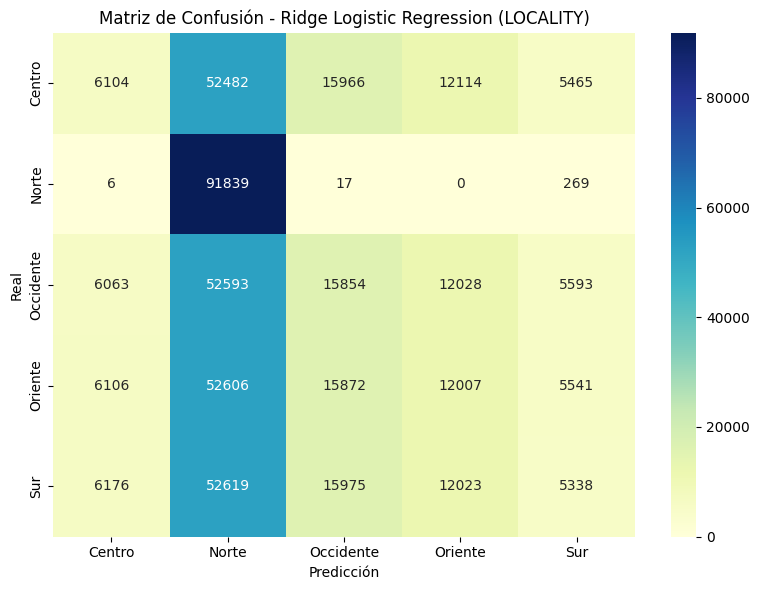

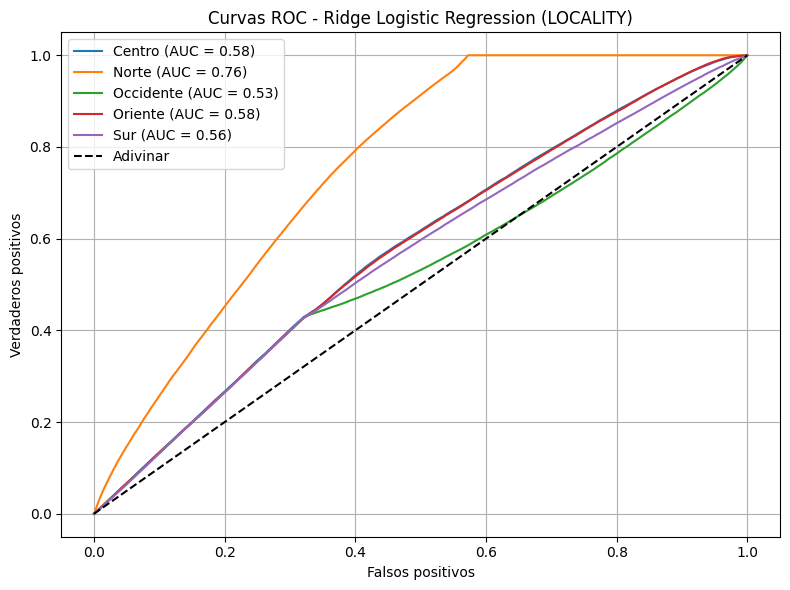

AUC promedio (macro): 0.6008


In [ ]:

from sklearn.linear_model import LogisticRegression


# === Codificar variable objetivo: LOCALITY ===
le = LabelEncoder()
df['LOCALITY_encoded'] = le.fit_transform(df['LOCALITY'])

# === Seleccionar variables de entrada (X) ===
features = ['T2M', 'RH2M', 'PRECTOTCORR', 'WS10M', 'WD10M',
            'PS', 'ALLSKY_SFC_UV_INDEX', 'ALLSKY_SFC_SW_DIFF',
            'T2MDEW', 'T2MWET', 'WS50M', 'SolarIndex']

X = df[features]
y = df['LOCALITY_encoded']

# === División train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === Escalar ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Definir modelo: Ridge (L2) ===
ridge = LogisticRegression(
    penalty='l2',      # Ridge
    solver='lbfgs',     # Elegido automáticamente por sklearn
    max_iter=500,      
    n_jobs=-1,         
    random_state=42
)

# === Validación cruzada (accuracy) ===
cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Promedio de accuracy en CV:", cv_scores.mean())

# === Entrenamiento final y predicción ===
start_time = time.time()

ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)
y_proba = ridge.predict_proba(X_test_scaled)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de cómputo (Ridge): {elapsed_time:.4f} segundos")

# === Reporte de clasificación ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# === Matriz de Confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='YlGnBu')
plt.title("Matriz de Confusión - Ridge Logistic Regression (LOCALITY)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === Curvas ROC por clase + AUC por clase ===
plt.figure(figsize=(8, 6))
auc_scores = []

for i, class_label in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test == i, y_proba[:, i])
    auc = roc_auc_score(y_test == i, y_proba[:, i])
    auc_scores.append(auc)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.title("Curvas ROC - Ridge Logistic Regression (LOCALITY)")
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === AUC promedio (macro) ===
auc_macro = np.mean(auc_scores)
print(f"AUC promedio (macro): {auc_macro:.4f}")


### **Lasso**

Cross-validation scores: [0.28533333 0.28366667 0.28657143 0.28728571 0.2882381 ]
Promedio de accuracy en CV: 0.2862190476190476
Tiempo de cómputo (Lasso): 5.0279 segundos
=== Classification Report ===
              precision    recall  f1-score   support

      Centro       0.24      0.03      0.06      8954
       Norte       0.30      1.00      0.47      9035
   Occidente       0.26      0.14      0.18      8987
     Oriente       0.21      0.01      0.01      9001
         Sur       0.25      0.26      0.26      9023

    accuracy                           0.29     45000
   macro avg       0.25      0.29      0.19     45000
weighted avg       0.25      0.29      0.19     45000



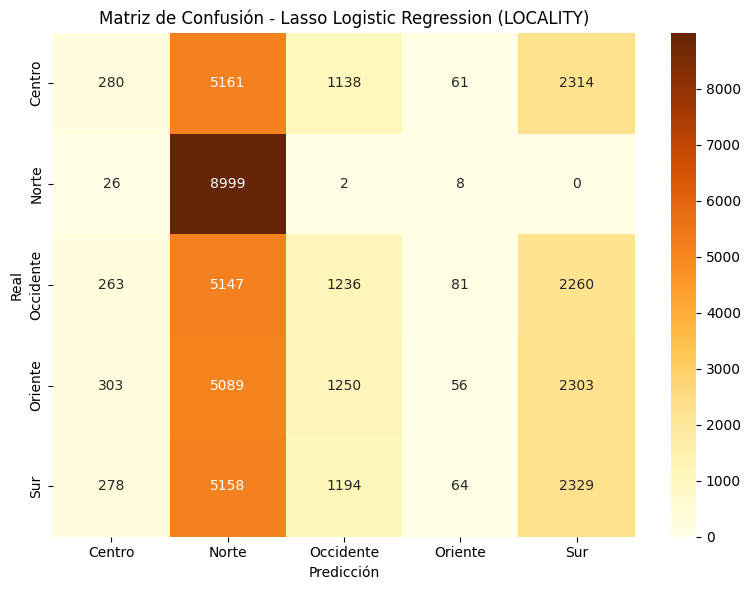

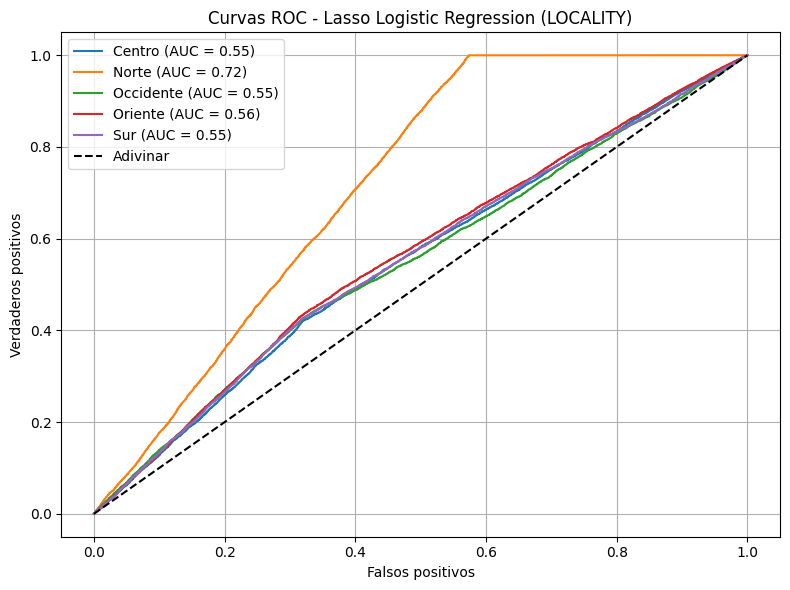

AUC promedio (macro): 0.5872


In [35]:


# === Codificar variable objetivo: LOCALITY ===
le = LabelEncoder()
df['LOCALITY_encoded'] = le.fit_transform(df['LOCALITY'])

# === Seleccionar variables de entrada (X) ===
features = ['T2M', 'RH2M', 'PRECTOTCORR', 'WS10M', 'WD10M',
            'PS', 'ALLSKY_SFC_UV_INDEX', 'ALLSKY_SFC_SW_DIFF',
            'T2MDEW', 'T2MWET', 'WS50M', 'SolarIndex']

# === 3. Tomar muestra del dataset (sin modificar df) ===
df_sampled = df.sample(n=150000, random_state=42)

# === Definir X, y ===
X = df_sampled[features]
y = df_sampled['LOCALITY_encoded']

# === División train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === Escalar ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Definir modelo: Lasso (L1) ===
lasso = LogisticRegression(
    penalty='l1',        
    solver='saga',       
    max_iter=3000,
     tol=1e-2,       
    n_jobs=-1,           
    random_state=42
)


# === Validación cruzada (accuracy) ===
cv_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Promedio de accuracy en CV:", cv_scores.mean())

# === Entrenamiento final y predicción ===
start_time = time.time()

lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)
y_proba = lasso.predict_proba(X_test_scaled)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de cómputo (Lasso): {elapsed_time:.4f} segundos")

# === Reporte de clasificación ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# === Matriz de Confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='YlOrBr')
plt.title("Matriz de Confusión - Lasso Logistic Regression (LOCALITY)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === Curvas ROC por clase + AUC por clase ===
plt.figure(figsize=(8, 6))
auc_scores = []

for i, class_label in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test == i, y_proba[:, i])
    auc = roc_auc_score(y_test == i, y_proba[:, i])
    auc_scores.append(auc)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.title("Curvas ROC - Lasso Logistic Regression (LOCALITY)")
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === AUC promedio (macro) ===
auc_macro = np.mean(auc_scores)
print(f"AUC promedio (macro): {auc_macro:.4f}")


### **Random Forest

**

## **Implementación de los modelos (con optimización)**

### **Optimización de KNN con (KD-Trees, Ball Trees, FAISS)**

#### **KD-Tree**

In [15]:
# === Definir modelo KNN con KD-Tree ===
knn_kdtree = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

# === Validación cruzada ===
cv_scores_kdtree = cross_val_score(knn_kdtree, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores (KD-Tree):", cv_scores_kdtree)
print("Promedio de accuracy en CV (KD-Tree):", cv_scores_kdtree.mean())

# === Entrenamiento final y predicción (medimos tiempo) ===
start_time = time.time()

knn_kdtree.fit(X_train_scaled, y_train)
y_pred_kdtree = knn_kdtree.predict(X_test_scaled)
y_proba_kdtree = knn_kdtree.predict_proba(X_test_scaled)

end_time = time.time()
elapsed_time_kdtree = end_time - start_time

print(f"Tiempo de cómputo (KNN con KD-Tree): {elapsed_time_kdtree:.4f} segundos")

# === Reporte de clasificación ===
print("=== Classification Report (KD-Tree) ===")
print(classification_report(y_test, y_pred_kdtree, target_names=le.classes_))


Cross-validation scores (KD-Tree): [0.22099519 0.2218139  0.22179995 0.22197309 0.22196379]
Promedio de accuracy en CV (KD-Tree): 0.22170918574600978
Tiempo de cómputo (KNN con KD-Tree): 20.4023 segundos
=== Classification Report (KD-Tree) ===
              precision    recall  f1-score   support

      Centro       0.19      0.34      0.24     92131
       Norte       0.34      0.48      0.40     92131
   Occidente       0.16      0.16      0.16     92131
     Oriente       0.18      0.11      0.14     92132
         Sur       0.10      0.01      0.03     92131

    accuracy                           0.22    460656
   macro avg       0.19      0.22      0.19    460656
weighted avg       0.19      0.22      0.19    460656



#### **Ball Trees**

In [ ]:

# === Definir modelo KNN con Ball-Tree ===
knn_balltree = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree')

# === Validación cruzada ===
cv_scores_balltree = cross_val_score(knn_balltree, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores (Ball-Tree):", cv_scores_balltree)
print("Promedio de accuracy en CV (Ball-Tree):", cv_scores_balltree.mean())

# === Entrenamiento final y predicción (medimos tiempo) ===
start_time = time.time()

knn_balltree.fit(X_train_scaled, y_train)
y_pred_balltree = knn_balltree.predict(X_test_scaled)
y_proba_balltree = knn_balltree.predict_proba(X_test_scaled)

end_time = time.time()
elapsed_time_balltree = end_time - start_time

print(f"Tiempo de cómputo (KNN con Ball-Tree): {elapsed_time_balltree:.4f} segundos")

# === Reporte de clasificación ===
print("=== Classification Report (Ball-Tree) ===")
print(classification_report(y_test, y_pred_balltree, target_names=le.classes_))  


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import classification_report, accuracy_score

# === Modelo con Ball-Tree ===
knn_balltree = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree')

start = time.time()
knn_balltree.fit(X_train_scaled, y_train)
y_pred_balltree = knn_balltree.predict(X_test_scaled)
end = time.time()

elapsed_time_balltree = end - start
print(f"⏱️ Tiempo de cómputo (Ball-Tree): {elapsed_time_balltree:.4f} segundos")
print(f"Accuracy (Ball-Tree): {accuracy_score(y_test, y_pred_balltree):.4f}")

print("=== Classification Report (Ball-Tree) ===")
print(classification_report(y_test, y_pred_balltree, target_names=le.classes_))


### **FAISS**

In [17]:
import faiss
import numpy as np
import time
from sklearn.metrics import accuracy_score, classification_report

# === Preparar datos para FAISS ===
X_train_faiss = np.ascontiguousarray(X_train_scaled.astype('float32'))
X_test_faiss = np.ascontiguousarray(X_test_scaled.astype('float32'))
y_train_array = np.array(y_train)

# === Crear índice FAISS ===
index = faiss.IndexFlatL2(X_train_faiss.shape[1])  # distancia euclidiana
index.add(X_train_faiss)

# === Buscar vecinos más cercanos con tiempo de cómputo ===
k = 2  # igual que el mejor k de KNN
start_time = time.time()
distances, indices = index.search(X_test_faiss, k)
end_time = time.time()

elapsed_time_faiss = end_time - start_time
print(f"Tiempo de cómputo (KNN con FAISS): {elapsed_time_faiss:.4f} segundos")

# === Predicción: clase más frecuente entre vecinos ===
y_pred_faiss = []

for idx_list in indices:
    vecinos = y_train_array[idx_list]
    pred_clase = np.bincount(vecinos).argmax()  # clase más común
    y_pred_faiss.append(pred_clase)

# === Evaluación ===
acc_faiss = accuracy_score(y_test, y_pred_faiss)
print(f"Accuracy con FAISS: {acc_faiss:.4f}")

print("=== Classification Report (FAISS) ===")
print(classification_report(y_test, y_pred_faiss, target_names=le.classes_))  


Tiempo de cómputo (KNN con FAISS): 243.8416 segundos
Accuracy con FAISS: 0.2202
=== Classification Report (FAISS) ===
              precision    recall  f1-score   support

      Centro       0.19      0.34      0.24     92131
       Norte       0.34      0.48      0.40     92131
   Occidente       0.16      0.16      0.16     92131
     Oriente       0.17      0.11      0.14     92132
         Sur       0.10      0.01      0.03     92131

    accuracy                           0.22    460656
   macro avg       0.19      0.22      0.19    460656
weighted avg       0.19      0.22      0.19    460656



### **Optimización de Bayes con Partial_fit**

In [48]:

# --- Entrenamiento por lotes con partial_fit ---
nb_batch_model = GaussianNB()
batch_size = 10000
n_samples = X_train.shape[0]
classes = np.unique(y_train)

start_time = time.time()

for i in range(0, n_samples, batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    
    if i == 0:
        nb_batch_model.partial_fit(X_batch, y_batch, classes=classes)
    else:
        nb_batch_model.partial_fit(X_batch, y_batch)

end_time = time.time()
batch_training_time = end_time - start_time
print(f"Tiempo de entrenamiento con partial_fit(): {batch_training_time:.4f} segundos")

# --- Evaluación ---
y_pred = nb_batch_model.predict(X_test)
y_score = nb_batch_model.predict_proba(X_test)

# === Reporte de clasificación con nombres ===
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))



Tiempo de entrenamiento con partial_fit(): 0.1582 segundos

Reporte de Clasificación:
              precision    recall  f1-score   support

      Centro       0.25      0.03      0.06     92131
       Norte       0.31      0.99      0.47     92131
   Occidente       0.19      0.02      0.03     92131
     Oriente       0.25      0.28      0.26     92132
         Sur       0.24      0.11      0.15     92131

    accuracy                           0.28    460656
   macro avg       0.25      0.28      0.19    460656
weighted avg       0.25      0.28      0.19    460656



### **Optimización de Ridge con Solver optimizado saga**

In [ ]:

from sklearn.linear_model import LogisticRegression


# === Codificar variable objetivo: LOCALITY ===
le = LabelEncoder()
df['LOCALITY_encoded'] = le.fit_transform(df['LOCALITY'])

# === Seleccionar variables de entrada (X) ===
features = ['T2M', 'RH2M', 'PRECTOTCORR', 'WS10M', 'WD10M',
            'PS', 'ALLSKY_SFC_UV_INDEX', 'ALLSKY_SFC_SW_DIFF',
            'T2MDEW', 'T2MWET', 'WS50M', 'SolarIndex']

X = df[features]
y = df['LOCALITY_encoded']

# === División train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === Escalar ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Definir modelo: Ridge (L2) ===
ridge = LogisticRegression(
    penalty='l2',      # Ridge
    solver='saga',     # Elegido automáticamente por sklearn
    max_iter=500,      
    n_jobs=-1,         
    random_state=42
)

# === Validación cruzada (accuracy) ===
cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Promedio de accuracy en CV:", cv_scores.mean())

# === Entrenamiento final y predicción ===
start_time = time.time()

ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)
y_proba = ridge.predict_proba(X_test_scaled)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de cómputo (Ridge): {elapsed_time:.4f} segundos")

# === Reporte de clasificación ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# === Matriz de Confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='YlGnBu')
plt.title("Matriz de Confusión - Ridge Logistic Regression (LOCALITY)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === Curvas ROC por clase + AUC por clase ===
plt.figure(figsize=(8, 6))
auc_scores = []

for i, class_label in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test == i, y_proba[:, i])
    auc = roc_auc_score(y_test == i, y_proba[:, i])
    auc_scores.append(auc)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.title("Curvas ROC - Ridge Logistic Regression (LOCALITY)")
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === AUC promedio (macro) ===
auc_macro = np.mean(auc_scores)
print(f"AUC promedio (macro): {auc_macro:.4f}")
